In [1]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colormaps as cm
from package import saveload

In [2]:
figsize=(12, 4)

In [3]:
def calculate_mean_betty(df: pd.DataFrame, array, dim=None):
    """
    Calculate mean betty numbers
    
    Parameters:
    -----------
    df : DataFrame with columns ['Birth', 'Death', 'Dimension', 'Space']
    
    array : list or np.array
        Array of values
        
    dim : int or None
        Dimension of topological space
        If that's None< that will be maximal dimension from dfs['Dimension']
    
    Returns:
    --------
    res : np.array shape (len(array), dim)
        Array of 
    """
    if dim is None:
        dim = df['Dimension'].max()
    res = np.zeros([len(array), dim])
    for i in range(len(array)):
        val = array[i]
        dfi = df[(df['Birth'] <= val)&(df['Death'] > val)]
        dfi = dfi.groupby(['Space', 'Dimension'], as_index=False).count()[['Space', 'Dimension', 'Birth']]
        dfi = dfi.groupby('Dimension', as_index=False).mean()
        index = dfi['Dimension'].values
        vals = dfi['Birth'].values
        res[i, index] = vals
    return res

In [4]:
def calculate_mean_EC(df: pd.DataFrame, array):
    """
    Calculate mean betty numbers
    
    Parameters:
    -----------
    df : DataFrame with columns ['Birth', 'Death', 'Dimension', 'Space']
    
    array : list or np.array
        Array of values
        
    
    Returns:
    --------
    res : np.array length len(array)
        Array of 
    """
    res = np.zeros(len(array))
    for i in range(len(array)):
        val = array[i]
        dfi = df[(df['Birth'] <= val)&(df['Death'] > val)][['Space', 'Dimension', 'Birth']]
        dfi = dfi.groupby(['Space', 'Dimension'], as_index=False).count()
        dfi.columns = ['Space', 'Dimension', 'Count']
        dfi['Summand EC'] = (-1)**dfi['Dimension'] * dfi['Count']
        dfi = dfi.groupby('Space', as_index=False).sum()['Summand EC']
        res[i] = dfi.mean()
    res[np.isnan(res)] = 0
    return res

In [5]:
def catch_zeros(x, y):
    # returns all zero arguments for graph y(x)
    ids = np.where(y[1:]*y[:-1] <= 0)[0]
    zeros = []
    for i in ids:
        x0, x1 = x[i], x[i+1]
        y0, y1 = abs(y[i]), abs(y[i+1])
        xz = x0 + (x1 - x0)*y0/(y0 + y1)
        zeros.append(xz)
    return np.array(zeros)

# Download and Prepare

## Download and Prepare FCC

In [6]:
size = 27
experiments = 100
filename = 'lab-results/lab_voronoiD3_tessellation_on_torus3d_aggregated/size{0}.csv'.format(size)
fcc_df = pd.read_csv(filename)
fcc_df.shape

(2845487, 4)

In [7]:
fcc_df_gc = fcc_df[fcc_df['Death'] == np.inf][['Space', 'Dimension', 'Birth']]

fcc_giant_births_dim1 = fcc_df_gc[fcc_df_gc['Dimension'] == 1][['Space', 'Birth']]
fcc_giant_births_dim1 = fcc_giant_births_dim1.sort_values(['Space', 'Birth'])
fcc_giant_births_dim1['Number'] = np.tile(np.arange(3), experiments)
fcc_giant_births_dim1_mean = fcc_giant_births_dim1[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

fcc_giant_births_dim2 = fcc_df_gc[fcc_df_gc['Dimension'] == 2][['Space', 'Birth']]
fcc_giant_births_dim2 = fcc_giant_births_dim2.sort_values(['Space', 'Birth'])
fcc_giant_births_dim2['Number'] = np.tile(np.arange(3), experiments)
fcc_giant_births_dim2_mean = fcc_giant_births_dim2[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

pd.DataFrame({'Mean Giant Birth Dim 1': fcc_giant_births_dim1_mean, 
              'Mean Giant Birth Dim 2': fcc_giant_births_dim2_mean}).transpose()

0         1         2
Mean Giant Birth Dim 1  0.135780  0.138391  0.141021
Mean Giant Birth Dim 2  0.794358  0.797446  0.801073

In [8]:
fcc_giant_births_dim1_var = fcc_giant_births_dim1[['Number', 'Birth']].groupby('Number').var()['Birth'].values
fcc_giant_births_dim2_var = fcc_giant_births_dim2[['Number', 'Birth']].groupby('Number').var()['Birth'].values
pd.DataFrame({'Variance Giant Birth Dim 1': fcc_giant_births_dim1_var, 
              'Variance Giant Birth Dim 2': fcc_giant_births_dim2_var}).transpose()

0         1        2
Variance Giant Birth Dim 1  0.000012  0.000012  0.00001
Variance Giant Birth Dim 2  0.000014  0.000011  0.00002

In [9]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
fcc_mean_betty = calculate_mean_betty(fcc_df, array, 4)
if (fcc_mean_betty[:, -1] == 0).all():
    matrix = np.random.random([experiments, size**3])
    fcc_births3d = np.sort(matrix, axis=-1)[:, -1]
    fcc_mean_betty[:, -1] = [(fcc_births3d <= i).sum()/experiments for i in array]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  4.0249 seconds.


In [10]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
fcc_mean_EC = calculate_mean_EC(fcc_df, array)
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  3.6760 seconds.


In [11]:
fcc_zeros_EC = catch_zeros(array, fcc_mean_EC)
fcc_zeros_EC = fcc_zeros_EC[fcc_zeros_EC > 0]
fcc_zeros_EC

array([0.16144708, 0.76313004])

## Download and Prepare BCC

In [12]:
size = 31
experiments = 100
filename = 'lab-results/lab_voronoiBCC_tessellation_on_torus3d_aggregated/size{0}.csv'.format(size)
bcc_df = pd.read_csv(filename)
bcc_df.shape

(1970942, 4)

In [13]:
bcc_df_gc = bcc_df[bcc_df['Death'] == np.inf][['Space', 'Dimension', 'Birth']]

bcc_giant_births_dim1 = bcc_df_gc[bcc_df_gc['Dimension'] == 1][['Space', 'Birth']]
bcc_giant_births_dim1 = bcc_giant_births_dim1.sort_values(['Space', 'Birth'])
bcc_giant_births_dim1['Number'] = np.tile(np.arange(3), experiments)
bcc_giant_births_dim1_mean = bcc_giant_births_dim1[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

bcc_giant_births_dim2 = bcc_df_gc[bcc_df_gc['Dimension'] == 2][['Space', 'Birth']]
bcc_giant_births_dim2 = bcc_giant_births_dim2.sort_values(['Space', 'Birth'])
bcc_giant_births_dim2['Number'] = np.tile(np.arange(3), experiments)
bcc_giant_births_dim2_mean = bcc_giant_births_dim2[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

pd.DataFrame({'Mean Giant Birth Dim 1': bcc_giant_births_dim1_mean, 
              'Mean Giant Birth Dim 2': bcc_giant_births_dim2_mean}).transpose()

0         1         2
Mean Giant Birth Dim 1  0.176516  0.179595  0.182610
Mean Giant Birth Dim 2  0.817094  0.820329  0.824191

In [14]:
bcc_giant_births_dim1_var = bcc_giant_births_dim1[['Number', 'Birth']].groupby('Number').var()['Birth'].values
bcc_giant_births_dim2_var = bcc_giant_births_dim2[['Number', 'Birth']].groupby('Number').var()['Birth'].values
pd.DataFrame({'Variance Giant Birth Dim 1': bcc_giant_births_dim1_var, 
              'Variance Giant Birth Dim 2': bcc_giant_births_dim2_var}).transpose()

0         1         2
Variance Giant Birth Dim 1  0.000017  0.000011  0.000011
Variance Giant Birth Dim 2  0.000018  0.000018  0.000023

In [15]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
bcc_mean_betty = calculate_mean_betty(bcc_df, array, 4)
if (bcc_mean_betty[:, -1] == 0).all():
    matrix = np.random.random([experiments, size**3])
    bcc_births3d = np.sort(matrix, axis=-1)[:, -1]
    bcc_mean_betty[:, -1] = [(bcc_births3d <= i).sum()/experiments for i in array]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  2.6400 seconds.


In [16]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
bcc_mean_EC = calculate_mean_EC(bcc_df, array)
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  2.3785 seconds.


In [17]:
bcc_zeros_EC = catch_zeros(array, bcc_mean_EC)
bcc_zeros_EC = bcc_zeros_EC[bcc_zeros_EC > 0]
bcc_zeros_EC

array([0.21138726, 0.78863589])

## Download and Prepare Cubical

In [18]:
size = 69
experiments = 100
filename = 'lab-results/lab_cubical_tessellation_on_torus3d_aggregated/size{0}.csv'.format(size)
cub_df = pd.read_csv(filename)
cub_df.shape

(12085306, 4)

In [19]:
cub_df_gc = cub_df[cub_df['Death'] == np.inf][['Space', 'Dimension', 'Birth']]

cub_giant_births_dim1 = cub_df_gc[cub_df_gc['Dimension'] == 1][['Space', 'Birth']]
cub_giant_births_dim1 = cub_giant_births_dim1.sort_values(['Space', 'Birth'])
cub_giant_births_dim1['Number'] = np.tile(np.arange(3), experiments)
cub_giant_births_dim1_mean = cub_giant_births_dim1[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

cub_giant_births_dim2 = cub_df_gc[cub_df_gc['Dimension'] == 2][['Space', 'Birth']]
cub_giant_births_dim2 = cub_giant_births_dim2.sort_values(['Space', 'Birth'])
cub_giant_births_dim2['Number'] = np.tile(np.arange(3), experiments)
cub_giant_births_dim2_mean = cub_giant_births_dim2[['Number', 'Birth']].groupby('Number').mean()['Birth'].values

pd.DataFrame({'Mean Giant Birth Dim 1': cub_giant_births_dim1_mean, 
              'Mean Giant Birth Dim 2': cub_giant_births_dim2_mean}).transpose()

0         1         2
Mean Giant Birth Dim 1  0.097873  0.099265  0.100511
Mean Giant Birth Dim 2  0.683935  0.686005  0.688288

In [20]:
cub_giant_births_dim1_var = cub_giant_births_dim1[['Number', 'Birth']].groupby('Number').var()['Birth'].values
cub_giant_births_dim2_var = cub_giant_births_dim2[['Number', 'Birth']].groupby('Number').var()['Birth'].values
pd.DataFrame({'Variance Giant Birth Dim 1': cub_giant_births_dim1_var, 
              'Variance Giant Birth Dim 2': cub_giant_births_dim2_var}).transpose()

0         1         2
Variance Giant Birth Dim 1  0.000004  0.000002  0.000002
Variance Giant Birth Dim 2  0.000008  0.000006  0.000010

In [21]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
cub_mean_betty = calculate_mean_betty(cub_df, array, 4)
if (cub_mean_betty[:, -1] == 0).all():
    matrix = np.random.random([experiments, size**3])
    cub_births3d = np.sort(matrix, axis=-1)[:, -1]
    cub_mean_betty[:, -1] = [(cub_births3d <= i).sum()/experiments for i in array]
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  15.0752 seconds.


In [22]:
clock = time.perf_counter()
n = 100
array = np.arange(0, 1 + 1/n, 1/n)
cub_mean_EC = calculate_mean_EC(cub_df, array)
print('Calculated in {0: .4f} seconds.'.format(time.perf_counter() - clock))

Calculated in  13.0503 seconds.


# Show Results

In [23]:
colors_EC = {'bcc': 'goldenrod', 
             'fcc': 'orangered', 
             'cub': 'brown'
            }
colors_gc = {'bcc': ['black', 'limegreen', 'seagreen', 'black'], 
             'fcc': ['black', 'deepskyblue', 'midnightblue', 'black'], 
             'cub': ['black', 'magenta', 'purple', 'black']
            }

/tmp/ipykernel_99288/103907017.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


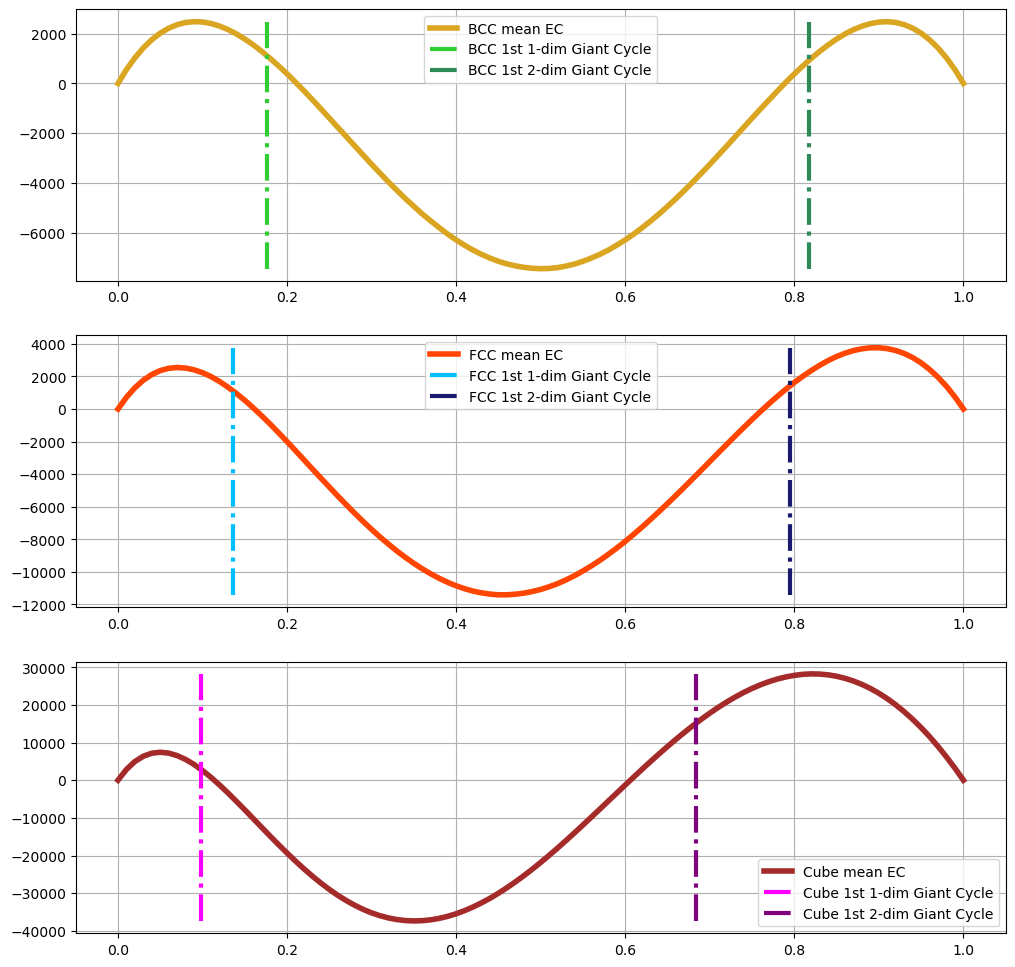

In [24]:
fig, axs = plt.subplots(3, figsize=(figsize[0], 3*figsize[1]))

axs[0].plot(array, bcc_mean_EC, color=colors_EC['bcc'], linewidth=4, label='BCC mean EC')
axs[1].plot(array, fcc_mean_EC, color=colors_EC['fcc'], linewidth=4, label='FCC mean EC')
axs[2].plot(array, cub_mean_EC, color=colors_EC['cub'], linewidth=4, label='Cube mean EC')

ypair = [(min(i), max(i)) for i in [bcc_mean_EC, 
                                    fcc_mean_EC, 
                                    cub_mean_EC
                                   ]]

axs[0].plot(bcc_giant_births_dim1_mean[0]*np.ones(2), ypair[0], 
            color=colors_gc['bcc'][1], linestyle='-.', linewidth=3, 
            label='BCC 1st 1-dim Giant Cycle')
axs[1].plot(fcc_giant_births_dim1_mean[0]*np.ones(2), ypair[1], 
            color=colors_gc['fcc'][1], linestyle='-.', linewidth=3, 
            label='FCC 1st 1-dim Giant Cycle')
axs[2].plot(cub_giant_births_dim1_mean[0]*np.ones(2), ypair[2], 
            color=colors_gc['cub'][1], linestyle='-.', linewidth=3, 
            label='Cube 1st 1-dim Giant Cycle')
axs[0].plot(bcc_giant_births_dim2_mean[0]*np.ones(2), ypair[0], 
            color=colors_gc['bcc'][2], linestyle='-.', linewidth=3, 
            label='BCC 1st 2-dim Giant Cycle')
axs[1].plot(fcc_giant_births_dim2_mean[0]*np.ones(2), ypair[1], 
            color=colors_gc['fcc'][2], linestyle='-.', linewidth=3, 
            label='FCC 1st 2-dim Giant Cycle')
axs[2].plot(cub_giant_births_dim2_mean[0]*np.ones(2), ypair[2], 
            color=colors_gc['cub'][2], linestyle='-.', linewidth=3, 
            label='Cube 1st 2-dim Giant Cycle')


for i in range(3):
    axs[i].legend()
    axs[i].grid(True)
fig.show()

# Hypothesis
$$
    \dim L = n
$$
$$
    t_k^{perc}(L) \approx 1 - t_{n-k}^{perc}(L^*)
$$
$$
    t_k^{ec}(L) \approx 1 - t_{n-k}^{ec}(L^*)
$$

# Analyze connection FCC and BCC

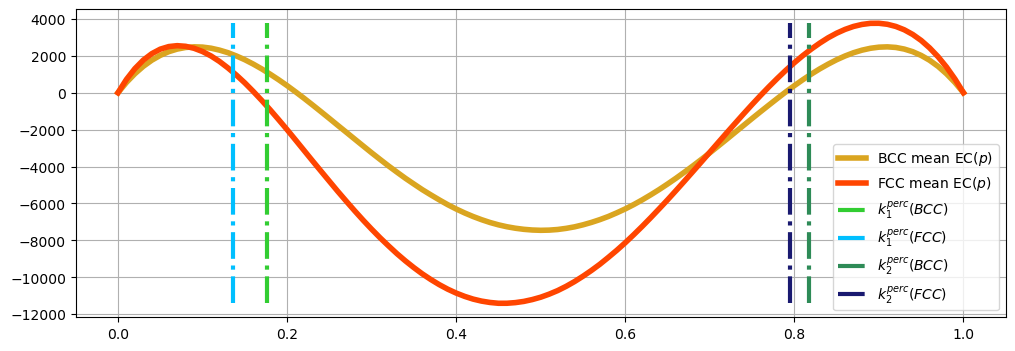

In [25]:
plt.figure(figsize=figsize)

plt.plot(array, bcc_mean_EC, color=colors_EC['bcc'], linewidth=4, label='BCC mean EC$(p)$')
plt.plot(array, fcc_mean_EC, color=colors_EC['fcc'], linewidth=4, label='FCC mean EC$(p)$')

ypair = np.concatenate([bcc_mean_EC, 
                        fcc_mean_EC
                       ])
ypair = min(ypair), max(ypair)

plt.plot(bcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][1], linestyle='-.', linewidth=3, 
         label='$k_1^{perc}(BCC)$')
plt.plot(fcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][1], linestyle='-.', linewidth=3, 
         label='$k_1^{perc}(FCC)$')
plt.plot(bcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][2], linestyle='-.', linewidth=3, 
         label='$k_2^{perc}(BCC)$')
plt.plot(fcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][2], linestyle='-.', linewidth=3, 
         label='$k_2^{perc}(FCC)$')


plt.legend()
plt.grid(True)
plt.show()

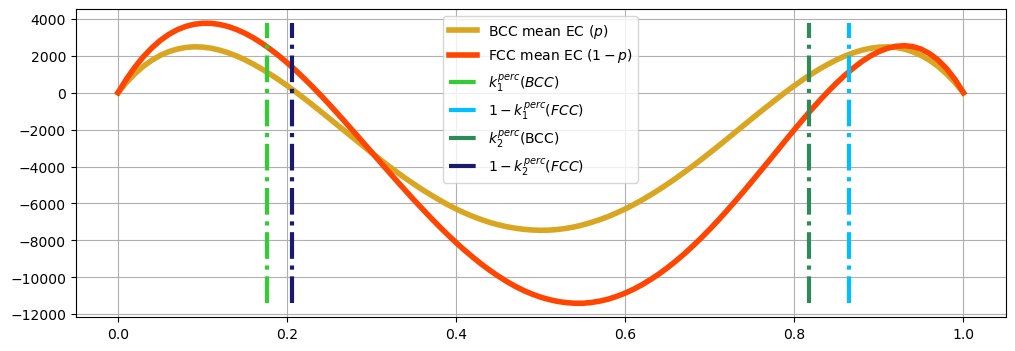

In [26]:
plt.figure(figsize=figsize)

plt.plot(array, bcc_mean_EC, color=colors_EC['bcc'], linewidth=4, label='BCC mean EC $(p)$')
plt.plot(1 - array, fcc_mean_EC, color=colors_EC['fcc'], linewidth=4, label='FCC mean EC $(1-p)$')

ypair = np.concatenate([bcc_mean_EC, fcc_mean_EC])
ypair = min(ypair), max(ypair)

plt.plot(bcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][1], linestyle='-.', linewidth=3, 
         label='$k_1^{perc}(BCC)$')
#         label='BCC 1st 1-dim Giant Cycle (p)')
plt.plot(1 - fcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][1], linestyle='-.', linewidth=3, 
         label='$1 - k_1^{perc}(FCC)$')
#        label='FCC 1st 1-dim Giant Cycle (1-p)')
plt.plot(bcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][2], linestyle='-.', linewidth=3, 
         label='$k_2^{perc}$(BCC)')
#         label='BCC 1st 2-dim Giant Cycle (p)')
plt.plot(1 - fcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][2], linestyle='-.', linewidth=3, 
         label='$1 - k_2^{perc}(FCC)$')
#         label='FCC 1st 2-dim Giant Cycle (1-p)')

plt.legend()
plt.grid(True)
plt.show()

## Restart drawing
11.10.2023

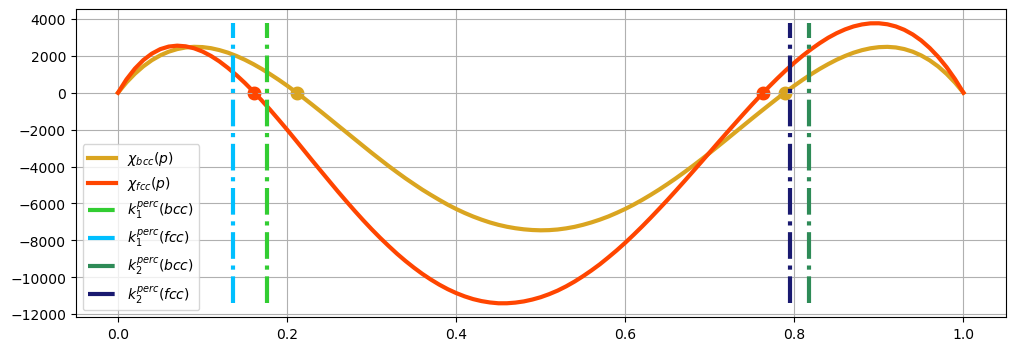

In [27]:
plt.figure(figsize=figsize)

plt.plot(array, bcc_mean_EC, color=colors_EC['bcc'], linewidth=3, label='$\chi_{bcc}(p)$')
plt.plot(array, fcc_mean_EC, color=colors_EC['fcc'], linewidth=3, label='$\chi_{fcc}(p)$')
plt.scatter(fcc_zeros_EC, np.zeros(2), color=colors_EC['fcc'], linewidth=4)
plt.scatter(bcc_zeros_EC, np.zeros(2), color=colors_EC['bcc'], linewidth=4)



ypair = np.concatenate([bcc_mean_EC, fcc_mean_EC])
ypair = min(ypair), max(ypair)

plt.plot(bcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][1], linestyle='-.', linewidth=3, 
         label='$k_1^{perc}(bcc)$')
plt.plot(fcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][1], linestyle='-.', linewidth=3, 
         label='$k_1^{perc}(fcc)$')
plt.plot(bcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][2], linestyle='-.', linewidth=3, 
         label='$k_2^{perc}(bcc)$')
plt.plot(fcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][2], linestyle='-.', linewidth=3, 
         label='$k_2^{perc}(fcc)$')


plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/EC_fccbcc_default.png')

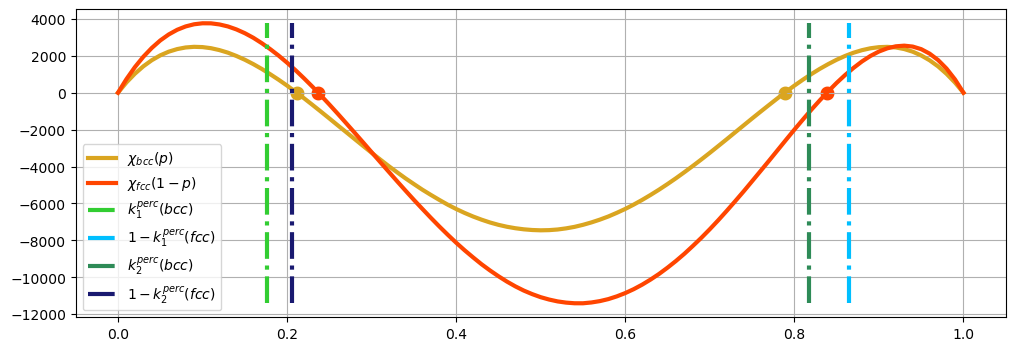

In [28]:
plt.figure(figsize=figsize)

plt.plot(array, bcc_mean_EC, color=colors_EC['bcc'], linewidth=3, label='$\chi_{bcc}(p)$')
plt.plot(1 - array, fcc_mean_EC, color=colors_EC['fcc'], linewidth=3, label='$\chi_{fcc}(1 - p)$')
plt.scatter(bcc_zeros_EC, np.zeros(2), color=colors_EC['bcc'], linewidth=4)
plt.scatter(1 - fcc_zeros_EC, np.zeros(2), color=colors_EC['fcc'], linewidth=4)



ypair = np.concatenate([bcc_mean_EC, fcc_mean_EC])
ypair = min(ypair), max(ypair)

plt.plot(bcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][1], linestyle='-.', linewidth=3, 
         label='$k_1^{perc}(bcc)$')
plt.plot(1 - fcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][1], linestyle='-.', linewidth=3, 
         label='$1 - k_1^{perc}(fcc)$')
plt.plot(bcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][2], linestyle='-.', linewidth=3, 
         label='$k_2^{perc}(bcc)$')
plt.plot(1 - fcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][2], linestyle='-.', linewidth=3, 
         label='$1 - k_2^{perc}(fcc)$')


plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/EC_fccbcc_fccreversed.png')

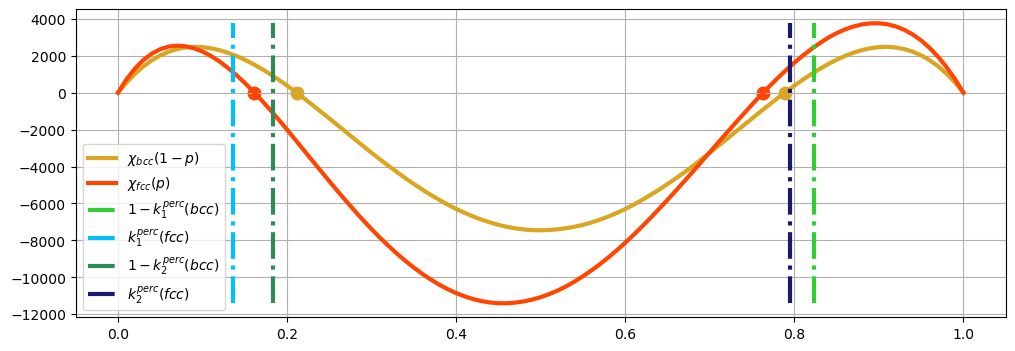

In [29]:
plt.figure(figsize=figsize)


plt.plot(1 - array, bcc_mean_EC, color=colors_EC['bcc'], linewidth=3, label='$\chi_{bcc}(1 - p)$')
plt.plot(array, fcc_mean_EC, color=colors_EC['fcc'], linewidth=3, label='$\chi_{fcc}(p)$')
plt.scatter(1 - bcc_zeros_EC, np.zeros(2), color=colors_EC['bcc'], linewidth=4)
plt.scatter(fcc_zeros_EC, np.zeros(2), color=colors_EC['fcc'], linewidth=4)



ypair = np.concatenate([bcc_mean_EC, fcc_mean_EC])
ypair = min(ypair), max(ypair)

plt.plot(1 - bcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][1], linestyle='-.', linewidth=3, 
         label='$1 - k_1^{perc}(bcc)$')
plt.plot(fcc_giant_births_dim1_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][1], linestyle='-.', linewidth=3, 
         label='$k_1^{perc}(fcc)$')
plt.plot(1 - bcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['bcc'][2], linestyle='-.', linewidth=3, 
         label='$1 - k_2^{perc}(bcc)$')
plt.plot(fcc_giant_births_dim2_mean[0]*np.ones(2), ypair, 
         color=colors_gc['fcc'][2], linestyle='-.', linewidth=3, 
         label='$k_2^{perc}(fcc)$')


plt.legend()
plt.grid(True)
plt.savefig('LaTeX/pics/EC_fccbcc_bccreversed.png')

In [32]:
kec1_fcc, kec2_fcc = fcc_zeros_EC
kec1_bcc, kec2_bcc = bcc_zeros_EC

print('$k_1^{ec}(fcc) = x$'.replace('x', '{0:.6f}'.format(kec1_fcc)))
print('$k_2^{ec}(fcc) = x$'.replace('x', '{0:.6f}'.format(kec2_fcc)))
print('$k_1^{ec}(bcc) = x$'.replace('x', '{0:.6f}'.format(kec1_bcc)))
print('$k_2^{ec}(bcc) = x$'.replace('x', '{0:.6f}'.format(kec2_bcc)))

print()
x = abs(kec1_fcc - kec1_bcc)
print('$|k_1^{ec}(fcc) - k_1^{ec}(bcc)| = x$'.replace('x', '{0:.6f}'.format(x)))
x = abs(kec2_fcc - kec2_bcc)
print('$|k_2^{ec}(fcc) - k_2^{ec}(bcc)| = x$'.replace('x', '{0:.6f}'.format(x)))

print()
x = abs(1 - kec1_bcc - kec2_fcc)
print('$|(1 - k_1^{ec}(bcc)) - k_2^{ec}(fcc)| = x$'.replace('x', '{0:.6f}'.format(x)))
x = abs(1 - kec2_bcc - kec1_fcc)
print('$|(1 - k_2^{ec}(bcc)) - k_1^{ec}(fcc)| = x$'.replace('x', '{0:.6f}'.format(x)))

$k_1^{ec}(fcc) = 0.161447$
$k_2^{ec}(fcc) = 0.763130$
$k_1^{ec}(bcc) = 0.211387$
$k_2^{ec}(bcc) = 0.788636$

$|k_1^{ec}(fcc) - k_1^{ec}(bcc)| = 0.049940$
$|k_2^{ec}(fcc) - k_2^{ec}(bcc)| = 0.025506$

$|(1 - k_1^{ec}(bcc)) - k_2^{ec}(fcc)| = 0.025483$
$|(1 - k_2^{ec}(bcc)) - k_1^{ec}(fcc)| = 0.049917$


$$k_1^{ec}(fcc) = 0.161447$$
$$k_2^{ec}(fcc) = 0.763130$$
$$k_1^{ec}(bcc) = 0.211387$$
$$k_2^{ec}(bcc) = 0.788636$$

$$|k_1^{ec}(fcc) - k_1^{ec}(bcc)| = 0.049940$$
$$|k_2^{ec}(fcc) - k_2^{ec}(bcc)| = 0.025506$$

$$|(1 - k_1^{ec}(bcc)) - k_2^{ec}(fcc)| = 0.025483$$
$$|(1 - k_2^{ec}(bcc)) - k_1^{ec}(fcc)| = 0.049917$$

In [35]:
kperc1_fcc, kperc2_fcc = fcc_giant_births_dim1_mean[0], fcc_giant_births_dim2_mean[0]
kperc1_bcc, kperc2_bcc = bcc_giant_births_dim1_mean[0], bcc_giant_births_dim2_mean[0]

print('$k_1^{perc}(fcc) = x$'.replace('x', '{0:.6f}'.format(kperc1_fcc)))
print('$k_2^{perc}(fcc) = x$'.replace('x', '{0:.6f}'.format(kperc2_fcc)))
print('$k_1^{perc}(bcc) = x$'.replace('x', '{0:.6f}'.format(kperc1_bcc)))
print('$k_2^{perc}(bcc) = x$'.replace('x', '{0:.6f}'.format(kperc2_bcc)))

print()
x = abs(kperc1_fcc - kperc1_bcc)
print('$|k_1^{perc}(fcc) - k_1^{perc}(bcc)| = x$'.replace('x', '{0:.6f}'.format(x)))
x = abs(kperc2_fcc - kperc2_bcc)
print('$|k_2^{perc}(fcc) - k_2^{perc}(bcc)| = x$'.replace('x', '{0:.6f}'.format(x)))

print()
x = abs(1 - kperc1_bcc - kperc2_fcc)
print('$|(1 - k_1^{perc}(bcc)) - k_2^{perc}(fcc)| = x$'.replace('x', '{0:.6f}'.format(x)))
x = abs(1 - kperc2_bcc - kperc1_fcc)
print('$|(1 - k_2^{perc}(bcc)) - k_1^{perc}(fcc)| = x$'.replace('x', '{0:.6f}'.format(x)))

$k_1^{perc}(fcc) = 0.135780$
$k_2^{perc}(fcc) = 0.794358$
$k_1^{perc}(bcc) = 0.176516$
$k_2^{perc}(bcc) = 0.817094$

$|k_1^{perc}(fcc) - k_1^{perc}(bcc)| = 0.040736$
$|k_2^{perc}(fcc) - k_2^{perc}(bcc)| = 0.022736$

$|(1 - k_1^{perc}(bcc)) - k_2^{perc}(fcc)| = 0.029126$
$|(1 - k_2^{perc}(bcc)) - k_1^{perc}(fcc)| = 0.047125$


$$k_1^{perc}(fcc) = 0.135780$$
$$k_2^{perc}(fcc) = 0.794358$$
$$k_1^{perc}(bcc) = 0.176516$$
$$k_2^{perc}(bcc) = 0.817094$$

$$|k_1^{perc}(fcc) - k_1^{perc}(bcc)| = 0.040736$$
$$|k_2^{perc}(fcc) - k_2^{perc}(bcc)| = 0.022736$$

$$|(1 - k_1^{perc}(bcc)) - k_2^{perc}(fcc)| = 0.029126$$
$$|(1 - k_2^{perc}(bcc)) - k_1^{perc}(fcc)| = 0.047125$$

In [31]:
assert False

AssertionError: 

## Check limit

In [36]:
sizes = np.arange(3, 28)

In [37]:
fcc_filename = 'lab-results/lab_voronoiD3_tessellation_on_torus3d_aggregated/size{0}.csv'
fcc_mean_birth1_sizes = []
fcc_mean_birth2_sizes = []
for size in sizes:
    df = pd.read_csv(fcc_filename.format(size))
    df = df[df['Death'] == np.inf]
    df['Number'] = np.arange(len(df)) % 7
    df1 = df[df['Number'] == 1]
    df2 = df[df['Number'] == 4]
    fcc_mean_birth1_sizes.append(df1['Birth'].mean())
    fcc_mean_birth2_sizes.append(df2['Birth'].mean())

In [38]:
bcc_filename = 'lab-results/lab_voronoiBCC_tessellation_on_torus3d_aggregated/size{0}.csv'
bcc_mean_birth1_sizes = []
bcc_mean_birth2_sizes = []
for size in sizes:
    df = pd.read_csv(bcc_filename.format(size))
    df = df[df['Death'] == np.inf]
    df['Number'] = np.arange(len(df)) % 7
    df1 = df[df['Number'] == 1]
    df2 = df[df['Number'] == 4]
    bcc_mean_birth1_sizes.append(df1['Birth'].mean())
    bcc_mean_birth2_sizes.append(df2['Birth'].mean())

In [39]:
fcc_mean_birth1_sizes, fcc_mean_birth2_sizes, bcc_mean_birth1_sizes, bcc_mean_birth2_sizes = np.array([fcc_mean_birth1_sizes, fcc_mean_birth2_sizes, bcc_mean_birth1_sizes, bcc_mean_birth2_sizes])

/tmp/ipykernel_99288/2691807015.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


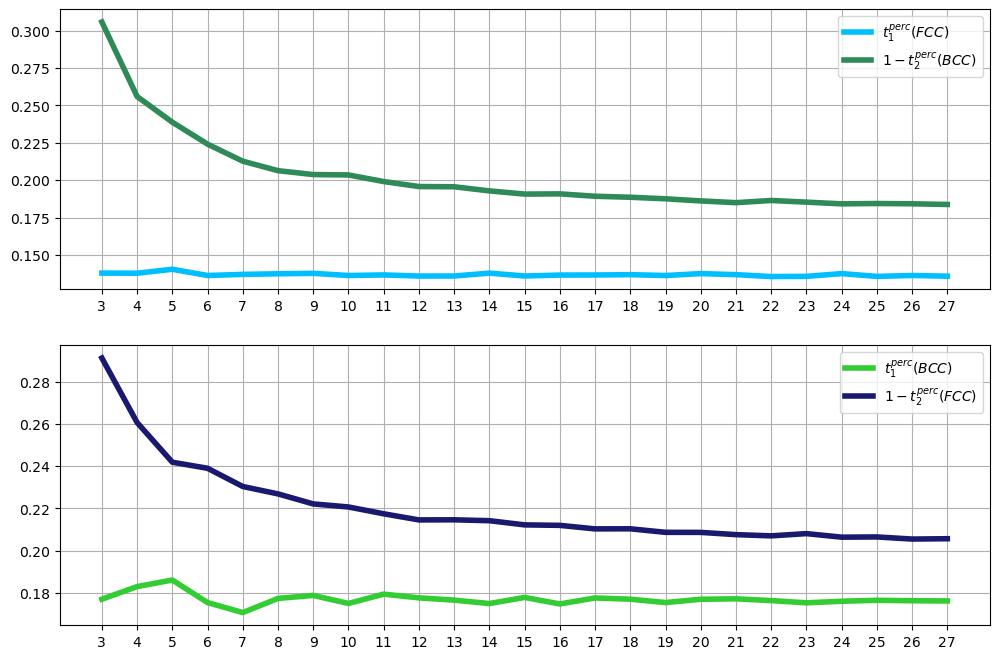

In [40]:
fig, axs = plt.subplots(2, figsize=(figsize[0], 2*figsize[1]))

axs[0].plot(sizes, fcc_mean_birth1_sizes, label='$t_1^{perc}(FCC)$', 
            linewidth=4, color=colors_gc['fcc'][1])
axs[0].plot(sizes, 1 - bcc_mean_birth2_sizes, label='$1 - t_2^{perc}(BCC)$', 
            linewidth=4, color=colors_gc['bcc'][2])

axs[1].plot(sizes, bcc_mean_birth1_sizes, label='$t_1^{perc}(BCC)$', 
            linewidth=4, color=colors_gc['bcc'][1])
axs[1].plot(sizes, 1 - fcc_mean_birth2_sizes, label='$1 - t_2^{perc}(FCC)$', 
            linewidth=4, color=colors_gc['fcc'][2])

xticks = sizes
axs[0].set_xticks(xticks)
axs[0].legend()
axs[0].grid(True)
axs[1].set_xticks(xticks)
axs[1].legend()
axs[1].grid(True)
fig.show()

# Analyze Cubical Lattice

$$
    \mathbb{Z}^3 = {\mathbb{Z}^3}^*
$$

/tmp/ipykernel_99288/815594914.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


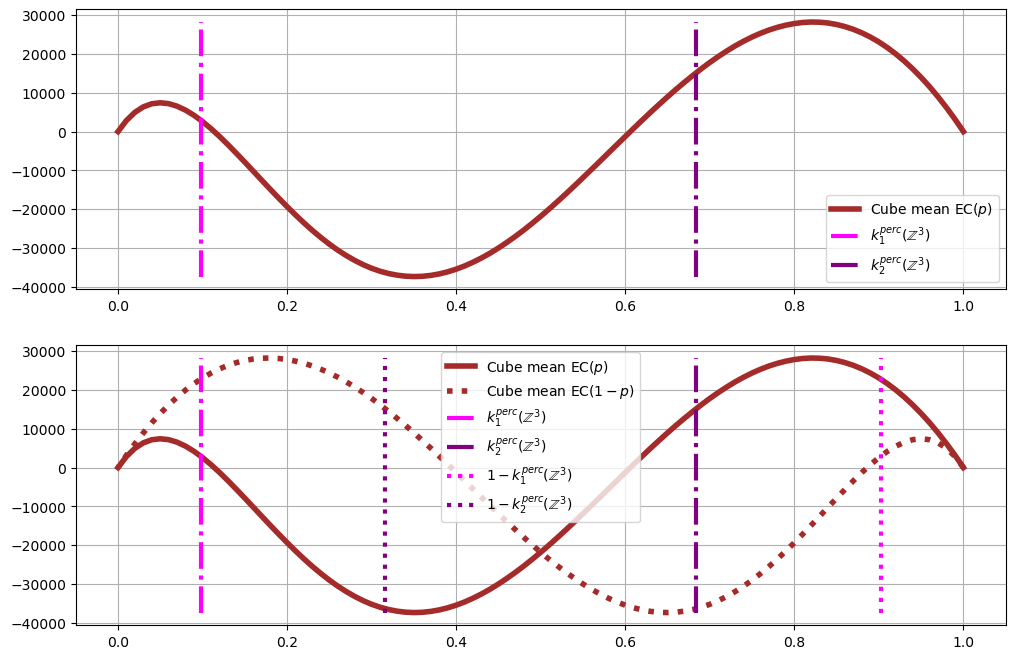

In [41]:
fig, axs = plt.subplots(2, figsize=(figsize[0], 2*figsize[1]))

ypair = min(cub_mean_EC), max(cub_mean_EC)

axs[0].plot(array, cub_mean_EC, color=colors_EC['cub'], linewidth=4, label='Cube mean EC$(p)$')

axs[0].plot(cub_giant_births_dim1_mean[0]*np.ones(2), ypair, 
            color=colors_gc['cub'][1], linestyle='-.', linewidth=3, 
            label='$k_1^{perc}(\mathbb{Z}^3)$')
axs[0].plot(cub_giant_births_dim2_mean[0]*np.ones(2), ypair, 
            color=colors_gc['cub'][2], linestyle='-.', linewidth=3, 
            label='$k_2^{perc}(\mathbb{Z}^3)$')

axs[1].plot(array, cub_mean_EC, color=colors_EC['cub'], linewidth=4, label='Cube mean EC$(p)$')
axs[1].plot(1-array, cub_mean_EC, color=colors_EC['cub'], linewidth=4, label='Cube mean EC$(1-p)$', linestyle=':')

axs[1].plot(cub_giant_births_dim1_mean[0]*np.ones(2), ypair, 
            color=colors_gc['cub'][1], linestyle='-.', linewidth=3, 
            label='$k_1^{perc}(\mathbb{Z}^3)$')
axs[1].plot(cub_giant_births_dim2_mean[0]*np.ones(2), ypair, 
            color=colors_gc['cub'][2], linestyle='-.', linewidth=3, 
            label='$k_2^{perc}(\mathbb{Z}^3)$')
axs[1].plot(1 - cub_giant_births_dim1_mean[0]*np.ones(2), ypair, 
            color=colors_gc['cub'][1], linestyle=':', linewidth=3, 
            label='$1 - k_1^{perc}(\mathbb{Z}^3)$')
axs[1].plot(1 - cub_giant_births_dim2_mean[0]*np.ones(2), ypair, 
            color=colors_gc['cub'][2], linestyle=':', linewidth=3, 
            label='$1 - k_2^{perc}(\mathbb{Z}^3)$')


axs[0].legend()
axs[0].grid(True)
axs[1].legend()
axs[1].grid(True)
fig.show()

Ну, тут явно что-то далеко от гипотезы...